In [1]:
%matplotlib inline

import numpy as np
from numpy import linalg as nla
import scipy as sp
from scipy import linalg as sla
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
from pprint import pprint
import SHFunctions as shf
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
np.set_printoptions(linewidth = 200)

In [2]:
def NewtonSchulz(p, A, Q, X0 = np.NAN, maxiter = 100, tol = np.NAN):
    if np.sum(np.isnan(X0)) > 0: # X0가 주어지지 않았을 때 m by m zero 행렬 처리
        X0 = np.eye(A.shape[0])
    
    if (p <= 0) or (not isinstance(p, int)): # p가 positive integer가 아닐 때 예외처리
        raise ValueError('p가 양의 정수가 아닙니다.')
        
    if A.shape[0] != A.shape[1]: # A가 square matrix가 아닐 때 예외처리
        raise ValueError('A가 정방행렬이 아닙니다.')
        
    if Q.shape[0] != Q.shape[1]: # Q가 square matrix가 아닐 때 예외처리
        raise ValueError('Q가 정방행렬이 아닙니다.')
        
    if (Q.shape[0] != A.shape[0]) or (A.shape[1] != Q.shape[1]): # A와 Q가 같은 크기 아닐 때 예외처리
        raise ValueError('A, Q가 같은 크기가 아닙니다.')
        
    m = A.shape[1] # m 초기화
    
    if np.isnan(tol): # tol이 주어지지 않았을 때 초기화
        tol = m * 1e-15
        
    Xs = [X0] # Xs는 X들을 담은 리스트로 초기화
    errs = [] # err 리스트 초기화
    S = np.zeros((A.shape[0],A.shape[1]))
    
    iter = 0
    err = 1e10 # error 초기화
    
    # Newton Iteration 시작
    t = time() # 시간체크
    while (err > tol) and (iter < maxiter):
        X0 = (1/p)*((p-1)*X0 + (Q - A.conj().transpose() @ X0 @ A)@nla.inv(nla.matrix_power(X0,p-1))) # Newton Sequence 적용
        err = nla.norm(nla.matrix_power(X0, p) - (Q - (A.conj()).transpose() @ X0 @ A), 'fro') # err 계산

        Xs.append(X0) # X_i 저장
        errs.append(err) # err 저장
        
        iter += 1
    
    calcultime = time() - t
    S = Xs[-1] # Solution
    
    # Vectorize of S - X_{i}와 X_{i+1} - X_{i} : cos 계산
    vSmX = []
    vXmX = []
    for i in range(len(Xs)-1):
        vSmX.append(np.reshape(S - Xs[i], S.shape[0]*S.shape[1], order='F'))
        vXmX.append(np.reshape(Xs[i+1] - Xs[i], S.shape[0]*S.shape[1], order='F'))
    cSX = []
    cXX = []
    for i in range(len(vSmX)-1):
        x1, y1 = vSmX[i+1], vSmX[i]
        x2, y2 = vXmX[i+1], vXmX[i]
        c1 = np.dot(x1,y1) / (nla.norm(x1,2)*nla.norm(y1,2))
        c2 = np.dot(x2,y2) / (nla.norm(x2,2)*nla.norm(y2,2))
        cSX.append(c1)
        cXX.append(c2)
    return {'sol':S, 'Xs':Xs, 'errs':errs, 'time':calcultime, 'SmX':vSmX, 'XmX':vXmX, 'csSmX':cSX, 'csXmX':cXX}

def Newton_pth(p, A, X0 = np.NAN, maxiter = 100, tol = np.NAN):
    if np.sum(np.isnan(X0)) > 0: # X0가 주어지지 않았을 때 m by m zero 행렬 처리
#         X0 = np.eye(A.shape[0])
        X0 = A
    
    if (p <= 0) or (not isinstance(p, int)): # p가 positive integer가 아닐 때 예외처리
        raise ValueError('p가 양의 정수가 아닙니다.')
        
    if A.shape[0] != A.shape[1]: # A가 square matrix가 아닐 때 예외처리
        raise ValueError('A가 정방행렬이 아닙니다.')
        
    m = A.shape[1] # m 초기화
    
    if np.isnan(tol): # tol이 주어지지 않았을 때 초기화
        tol = m * p * 1e-15
        
    Xs = [X0] # Xs는 X들을 담은 리스트로 초기화
    errs = [] # err 리스트 초기화
    S = np.zeros((A.shape[0],A.shape[1]))
    
    iter = 0
    err = 1e10 # error 초기화
    
    # Newton Iteration 시작
    t = time() # 시간체크
    while (err > tol) and (iter < maxiter):
        X0 = (1/p)*((p-1)*X0 + A@nla.inv(nla.matrix_power(X0,p-1))) # Newton Sequence 적용
        err = nla.norm(nla.matrix_power(X0, p) - A, 'fro') # err 계산

        Xs.append(X0) # X_i 저장
        errs.append(err) # err 저장
        
        iter += 1
    
    calcultime = time() - t
    S = Xs[-1] # Solution
    
    # Vectorize of S - X_{i}와 X_{i+1} - X_{i} : cos 계산
    vSmX = []
    vXmX = []
    for i in range(len(Xs)-1):
        vSmX.append(np.reshape(S - Xs[i], S.shape[0]*S.shape[1], order='F'))
        vXmX.append(np.reshape(Xs[i+1] - Xs[i], S.shape[0]*S.shape[1], order='F'))
    cSX = []
    cXX = []
    for i in range(len(vSmX)-1):
        x1, y1 = vSmX[i+1], vSmX[i]
        x2, y2 = vXmX[i+1], vXmX[i]
        c1 = np.dot(x1,y1) / (nla.norm(x1,2)*nla.norm(y1,2))
        c2 = np.dot(x2,y2) / (nla.norm(x2,2)*nla.norm(y2,2))
        cSX.append(c1)
        cXX.append(c2)
    return {'sol':S, 'Xs':Xs, 'errs':errs, 'time':calcultime, 'SmX':vSmX, 'XmX':vXmX, 'csSmX':cSX, 'csXmX':cXX}



In [3]:
p = 4
A = np.random.rand(10,10) * .2
Q = np.eye(10)
for i in range(10):
    for j in range(i,10):
        A[i,j] = 0
A

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.17919946, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.09332464, 0.15486898, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.14368892, 0.13856193, 0.12934243, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.094201  , 0.11790047, 0.07252623, 0.1407446 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00863026, 0.07274265, 0.00077857, 0.15766783, 0.16617393, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.18683141, 0.14549779, 0.19481682, 0.19763545, 0.19167287, 0.165026  , 0.        , 0.        , 0.        , 0.        ],
       [0.08398684, 0.08766854, 0.14611122, 0.14470321, 0.07965433, 0.12646772, 0.0873089 , 0.   

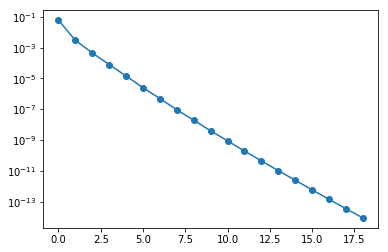

In [4]:
Ss = NewtonSchulz(p, A, Q)
ax = plt.subplot(111)
ax.semilogy(Ss['errs'],'-o')

array([[1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.88242979, 0.97896313, 0.98566605, 0.99478059, 0.99550014, 0.9978037 , 0.99996758, 0.99959594, 0.99877272, 1.        ],
       [0.86075719, 0.97922032, 0.98546009, 0.99481174, 0.99551682, 0.9978071 , 0.99996786, 0.99959795, 0.99878255, 1.        ],
       [0.86111041, 0.97939354, 0.98545801, 0.99482278, 0.99552204, 0.99780768, 0.99996791, 0.99959816, 0.99878279, 1.        ],
       [0.86111966, 0.97939067, 0.98545685, 0.99482303, 0.99552171, 0.99780768, 0.99996791, 0.99959815, 0.99878278, 1.        ],
       [0.86112205, 0.97939056, 0.98545681, 0.9948231 , 0.99552169, 0.99780768, 0.99996791, 0.99959815, 0.99878278, 1.        ],
       [0.86112292, 0.97939054, 0.98545679, 0.99482312, 0.99552168, 0.99780768, 0.99996791, 0.99959815, 0.99878278, 1.        ],
       [0.86112292, 0.97939052, 0.98545679, 0.99482312, 0.99552168, 0.99780768, 0.99996791, 0.999

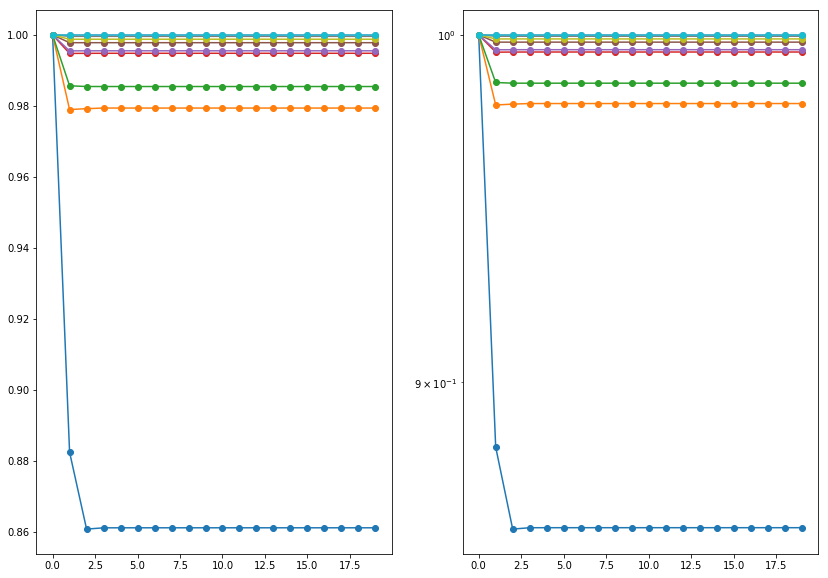

In [5]:
ds = np.zeros((len(Ss['Xs']),Ss['Xs'][0].shape[0]))
Xs = []
i = 0
for Xi in Ss['Xs']:
    ds[i][:], X = nla.eig(Xi)
    Xs.append(X)
    i += 1

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(ds.shape[1]):
    ax1.plot(ds[:,i],'-o')
    ax2.semilogy(np.abs(ds[:,i]),'-o')

xn = []
for i in range(len(Xs)-1):
    x = np.zeros((Xs[i].shape[1]))
    for j in range(Xs[i].shape[1]):
        if np.sign(Xs[i][1,j]) == np.sign(Xs[i+1][1,j]):
            x[j] = nla.norm(Xs[i][:,j] - Xs[i+1][:,j])
        else:
            x[j] = nla.norm(Xs[i][:,j] + Xs[i+1][:,j])
    xn.append(x)
pprint(ds)

In [6]:
for i in range(len(Ss['Xs'])-1):
    print("XiXii - XiiXi : {:3.10e}".format(nla.norm(Ss['Xs'][i] @ Ss['Xs'][i+1] - Ss['Xs'][i+1] @ Ss['Xs'][i])))

XiXii - XiiXi : 0.0000000000e+00
XiXii - XiiXi : 3.2771109766e-04
XiXii - XiiXi : 8.8991183224e-05
XiXii - XiiXi : 1.4839316598e-05
XiXii - XiiXi : 2.6498873504e-06
XiXii - XiiXi : 4.8456198944e-07
XiXii - XiiXi : 9.0591519537e-08
XiXii - XiiXi : 1.8018233311e-08
XiXii - XiiXi : 3.6508238906e-09
XiXii - XiiXi : 7.8662061855e-10
XiXii - XiiXi : 1.7156093349e-10
XiXii - XiiXi : 3.9126496519e-11
XiXii - XiiXi : 8.9895483791e-12
XiXii - XiiXi : 2.1239148441e-12
XiXii - XiiXi : 5.0473810172e-13
XiXii - XiiXi : 1.2199078650e-13
XiXii - XiiXi : 2.9689464945e-14
XiXii - XiiXi : 7.3415359639e-15
XiXii - XiiXi : 1.7838682489e-15
